In [1]:
#general definitions and imports
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import logging
logging.Logger.disabled=True

import os
import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='CRITICAL')

import numpy as np
import matplotlib.pyplot as plt

import ipytest
ipytest.autoconfig()
from pytest import approx

from pathlib import Path

from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Probe.Plot import plot
from PySpice.Math import *

import schemdraw
import schemdraw.elements as elm
from schemdraw import dsp
from schemdraw import logic

## setup spice library path
directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)
## set the project directory as directory_path
directory_path = Path(os.path.abspath('')).resolve()

In [2]:
# definitions
        
class VoltageDivider(SubCircuitFactory):
    __name__ = 'voltage_divider'
    __nodes__ = ('n1', 'n2', 'n3' )
    def __init__(self, R=100@u_kΩ, w=0.4, name='voltage_divider'):
        self.__name__ = name
        super().__init__()
        self.R(1, 'n1', 'n2', R * w)
        self.R(2, 'n2', 'n3', R * (1.0-w) )

In [3]:
%%run_pytest[clean] -qq --json=build/pegel-test.json

# test the input buffers
def test_buffer_1a_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_U1-Pad1_"]) 
    assert result == approx( 5, rel=1e-3 )

def test_buffer_1b_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_U1-Pad6_"]) 
    assert result == approx( 5, rel=1e-3 )

def test_buffer_2a_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_U2-Pad1_"]) 
    assert result == approx( 5, rel=1e-3 )

def test_buffer_2b_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_U2-Pad6_"]) 
    assert result == approx( 5, rel=1e-3 )

# test the output amplifier
def test_output_amplifier_1_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["OUTa"]) 
    assert result == approx( 5, rel=1e-3 )

def test_output_amplifier_2_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["OUTb"]) 
    assert result == approx( 5, rel=1e-3 )

#test the trimpot voltage
def test_trimpot_1_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_R7-Pad1_"]) 
    assert result == approx( 0, rel=1e-1 )

def test_trimpot_2_voltage():
    simulator = load().simulator(temperature=25, nominal_temperature=25)
    analysis_op = simulator.operating_point()
    result = float(analysis_op["Net-_R10-Pad2_"]) 
    assert result == approx( 0, rel=1e-1 )


def load(div1=0.5, div2=0.5):
    kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
    parser = SpiceParser(path=str(kicad_netlist_path))

    circuit = parser.build_circuit(ground=5)
    circuit.include(spice_library['OPA2134'])
    circuit.include(spice_library['OPA2134d'])
    circuit.include(spice_library['AD633'])

    circuit.V('1', '+15V', circuit.gnd, 'DC 15')
    circuit.V('2', '-15V', circuit.gnd, 'DC -15')
    circuit.V('3', '+5V', circuit.gnd, 'DC 5')
    circuit.V('4', 'Xa', circuit.gnd, 'DC 5')
    circuit.V('5', 'Ya', circuit.gnd, 'DC 5')
    circuit.V('6', 'Xb', circuit.gnd, 'DC 5')
    circuit.V('7', 'Yb', circuit.gnd, 'DC 5')

    for c in ( VoltageDivider(R=100@u_kΩ, w=div1, name='voltage_divider_1'), 
            VoltageDivider(R=100@u_kΩ, w=div2, name='voltage_divider_2') ):
        circuit.subcircuit(c)

    return circuit 


....F.                                                                   [100%]
=================================== FAILURES ===================================
_____________________________ test_trimpot_voltage _____________________________

    def test_trimpot_voltage():
        simulator = load().simulator(temperature=25, nominal_temperature=25)
        analysis_op = simulator.operating_point()
        result = float(analysis_op["Net-_R8-Pad2_"])
>       assert result == approx( 0, rel=1e-1 )
E       assert -2.1085450543264016e-06 == 0 ± 1.0e-12
E        +  where 0 ± 1.0e-12 = approx(0, rel=0.1)

<ipython-input-3-431ee42b9029>:35: AssertionError
- generated json report: /home/etienne/Documents/elektrophon/content/pegel/build/pegel-test.json -
=========================== short test summary info ============================
FAILED tmphkx3yhsd.py::test_trimpot_voltage - assert -2.1085450543264016e-06 ...


Pegel is a voltage controlled amplifier (VCA). There are various designs to implement a VCA. rod elliott (ESP) has an article on VCA techniques [[1][1]]. diy synthesizer modules are usualy designed with an integrated VCA chip [[2][2]] or with a differential amplifier [[3][3]]. The integrated VCA chips are either obsolete or rather expensive. The differential amplifier can be built with transistors only. the design has some downsides. Even in the simulation the result is not symetryc and has a dc offset from the control voltage. This needs a lot of trimming to get an accurate result. but the biggest downside is, that this design can not do proper amplitude modulation (am). when the carrier signal goes below zero the base signal is completely muted.
{: class="mt-6"}  

# construction
{: class="subtitle is-lowercase"}

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


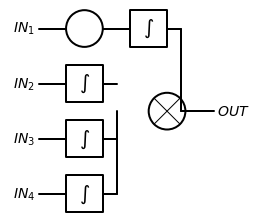

In [5]:
d = schemdraw.Drawing(inches_per_unit=0.6)

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 0*d.unit], lftlabel='$IN_4$'))
D1 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))
d.add(elm.Line( "up", l=0.75*d.unit))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 0.5*d.unit], lftlabel='$IN_3$'))
D2 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 1*d.unit], lftlabel='$IN_2$'))
D3 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))

d.add(elm.Line( "right", l=d.unit/4, xy=[0, 1.5*d.unit], lftlabel='$IN_1$'))
Q1 = d.add(dsp.Circle())
d.add(elm.Line( "right", l=d.unit/4))

D4 = d.add(dsp.Square(label='$\int$'))
d.add(elm.Line( "right", l=d.unit/8))
d.add(elm.Line( "down", l=0.75*d.unit))
d.add(elm.Line( "right", l=d.unit*0.30))

S = d.add(dsp.Mixer(xy=[d.unit, 0.75*d.unit]))
d.add(elm.Line( "right", l=d.unit/4, rgtlabel='$OUT$'))


d.draw()


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


In [6]:
#load the kicad schema
directory_path = Path(os.path.abspath('')).resolve()
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))


In [7]:
#ringmodulation
ringmod_schema = parser.build_circuit(ground=5)
ringmod_schema.include(spice_library['TL072c'])
ringmod_schema.include(spice_library['AD633'])

ringmod_schema.V('1', '+15V', ringmod_schema.gnd, 'DC 15')
ringmod_schema.V('2', '-15V', ringmod_schema.gnd, 'DC -15')
ringmod_schema.V('3', 'IN_Xa', ringmod_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 1k)')
ringmod_schema.V('4', 'IN_Ya', ringmod_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 100)')
ringmod_schema.V('5', 'IN_Za', ringmod_schema.gnd, 'DC 0V AC 0V')

#simulator = ringmod_schema.simulator(temperature=25, nominal_temperature=25)
#analysis_ringmod = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

VoltageSource V5

In [8]:
#amplitude modulation
am_schema = parser.build_circuit(ground=5)
am_schema.include(spice_library['TL072c'])
am_schema.include(spice_library['AD633'])

am_schema.V('1', '+15V', am_schema.gnd, 'DC 15')
am_schema.V('2', '-15V', am_schema.gnd, 'DC -15')
am_schema.V('3', 'IN_Xa', am_schema.gnd, 'DC 10V AC 5V SIN(0V 5V 1k)')
am_schema.V('4', 'IN_Ya', am_schema.gnd, 'DC 5V AC 5V SIN(0V 5V 100)')
am_schema.V('5', 'IN_Za', am_schema.gnd, 'DC 5V AC 5V SIN(0V 2.5V 1k)')

#simulator = am_schema.simulator(temperature=25, nominal_temperature=25)
#analysis_am = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

VoltageSource V5

In [9]:
#vca
vca_schema = parser.build_circuit(ground=5)
vca_schema.include(spice_library['TL072c'])
vca_schema.include(spice_library['AD633'])

vca_schema.V('1', '+15V', vca_schema.gnd, 'DC 15')
vca_schema.V('2', '-15V', vca_schema.gnd, 'DC -15')
vca_schema.V('3', 'IN_Xa', vca_schema.gnd, 'DC 10V AC 5V SIN(0V 5V 1k)')
vca_schema.V('4', 'IN_Ya', vca_schema.gnd, 'DC 5V AC 5V PULSE(0V 10V 1m 1m 15m 1m)')
vca_schema.V('5', 'IN_Za', vca_schema.gnd, 'DC 0V AC 0V')

#simulator = vca_schema.simulator(temperature=25, nominal_temperature=25)
#analysis_vca = simulator.transient(step_time=10@u_us, end_time=20@u_ms)

VoltageSource V5

# bom
{: class="subtitle is-lowercase mt-6"}

main circuit
{: class="is-size-6 has-text-weight-semibold mt-6"}

{% include bom.html content="summe-main-bom" %}
{% include callouts.html %}
{% include reports.html%}

# calibration
{: class="subtitle is-lowercase"}

there is no calibration needed. but the potentiomenter knobs have to be aliged to center position.

# usage
{: class="subtitle is-lowercase"}

the input jacks are wired to 5 volts when nothing is connected.

all channels are mixed to the out jack. when something is connected to the channel out, this channel is removed from the overall mix.

_mixer_
* connect the different channels from audio or cv sources to the in jacks.
* connect the out jack to something
* turn the pots clockwise to adjust the volume.

_attenuverter_
* connect all or a single channel. 
* when you turn the pot knob counter clockwise the signal is inverted.


# *references*
{: class="subtitle is-lowercase"}

- [VCA Techniques Investigated](https://sound-au.com/articles/vca-techniques.html) Rod Elliott (ESP).
- [Popular Electronics](https://tinaja.com/glib/pop_elec/mus_keying_vca_1+2_75.pdf) Keyiing and VCA citcuits for electronic music instruments.
- [VCA-1](https://www.birthofasynth.com/Thomas_Henry/Pages/VCA-1.html) Thomas Henry CA3080 VCA.
- [VCA-3](https://www.schmitzbits.de/vca3.png) René Schmitz differential pair VCA.
- [#223](https://www.youtube.com/watch?v=7nmmb0pqTU0&t=2s): Basics of the Gilbert Cell | Analog Multiplier | Mixer | Modulator
- [#224](https://www.youtube.com/watch?v=38OQub2Vi2Q): AM & DSB-SC Modulation with the Gilbert Cell
- [Analog Devices](https://www.analog.com/media/en/training-seminars/design-handbooks/ADI_Multiplier_Applications_Guide.pdf): Analog multiplier application guide 
- [AD633](https://www.analog.com/media/en/technical-documentation/data-sheets/AD633.pdf): Datasheet 
{: class="mb-6"}
